Assignment 3

Objective:
Develop a deep learning model to classify images from the Stanford Dogs dataset. The goal is to experiment with different neural network architectures and optimization techniques to achieve the best possible classification accuracy.

Dataset:
Use the Stanford Dogs DatasetLinks to an external site. available in TensorFlow Datasets. This dataset contains images of 120 breeds of dogs from around the world and is commonly used for fine-grained image categorization.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.image import resize_with_crop_or_pad


The below code is preparing the Stanford Dogs dataset for use, extracting class labels, and printing a few labels to give an idea of the dataset's structure. The dataset consists of images of dogs, and each image is associated with a specific dog breed label.

In [3]:
# Load the Stanford Dogs dataset
(train_data, test_data), info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
)

# Get the class labels from the info object
class_labels = info.features['label'].names

# Extract labels for training set
train_labels = [label for _, label in tfds.as_numpy(train_data)]

# Extract labels for test set
test_labels = [label for _, label in tfds.as_numpy(test_data)]

# Print the first few labels for training and test sets
print("Training Labels:", train_labels[:5])
print("Test Labels:", test_labels[:5])


Training Labels: [36, 118, 46, 103, 113]
Test Labels: [67, 84, 57, 12, 88]


In [4]:
# Check if 'train' split exists
if 'train' in info.splits:
    print("Training split exists.")
    print(f"Number of examples in training split: {info.splits['train'].num_examples}")
else:
    print("Training split does not exist.")

Training split exists.
Number of examples in training split: 12000


In [5]:
# Check if 'test' split exists
if 'train' in info.splits:
    print("Training split exists.")
    print(f"Number of examples in training split: {info.splits['test'].num_examples}")
else:
    print("Training split does not exist.")

Training split exists.
Number of examples in training split: 8580


In [6]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

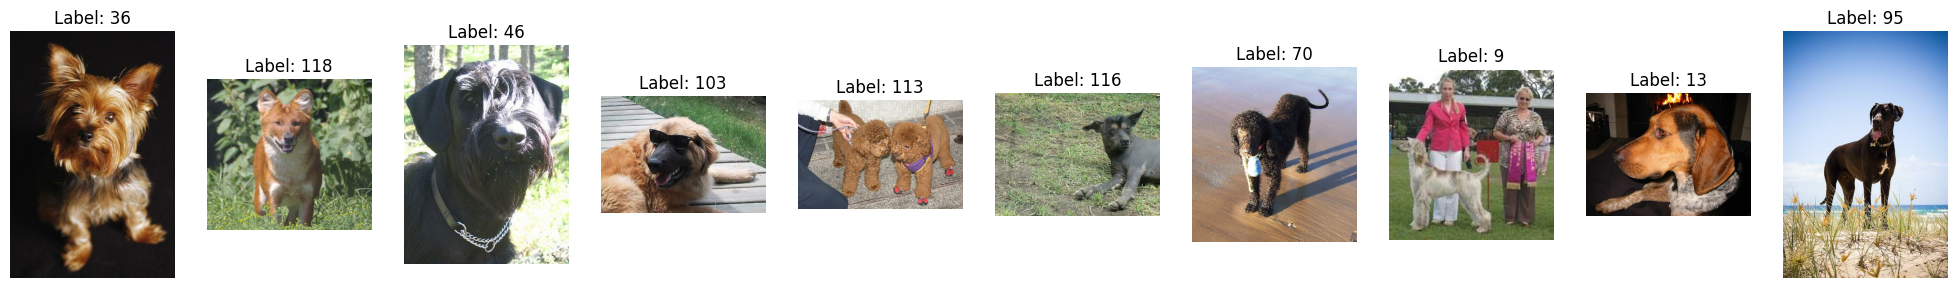

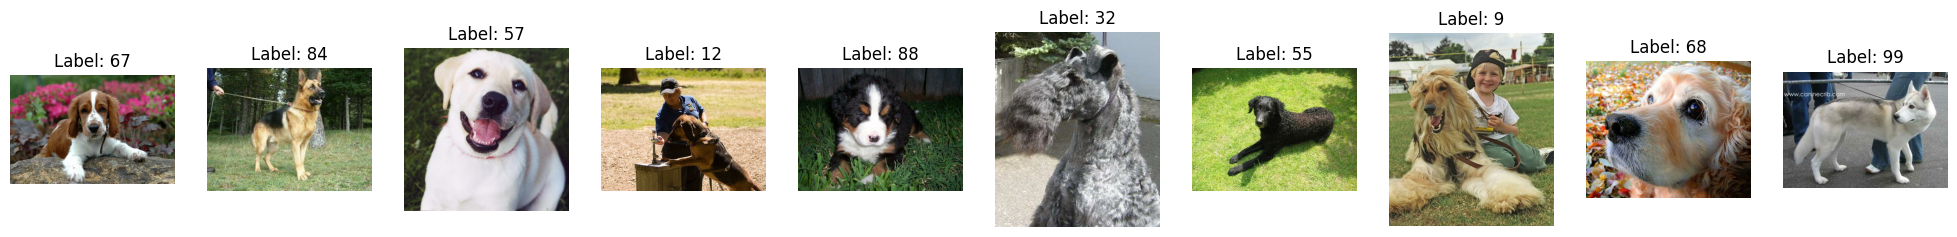

In [8]:
# Function to display images
def display_images(dataset, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(25, 25))
    for i, (image, label) in enumerate(dataset.take(num_images)):

        image = image.numpy()
        label = label.numpy()

        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

display_images(train_data, num_images=10)
display_images(test_data, num_images=10)


Setting `IMG_SIZE = (128, 128)` indicates that the images in the Stanford Dogs dataset will be resized to a square shape with dimensions 128x128 pixels. This is because Smaller images reduce the computational load during training and inference. Training models on smaller images can be faster, and it requires less memory. Also, Deep learning models often require a fixed input size. Resizing images helps manage memory constraints, especially when working with limited GPU memory.

In [9]:
IMG_SIZE = (128, 128)

The preprocess function is typically used as a preprocessing step for the input images and labels in a TensorFlow dataset pipeline.


In [10]:
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE) / 255.0  # Resize and normalize
    image = resize_with_crop_or_pad(image, 128, 128)  # Ensure consistent shape
    label = tf.one_hot(label, depth=120)  # One-hot encode labels
    return image, label

In [11]:
# Apply preprocessing to the datasets
train_dataset = train_data.map(preprocess)
test_dataset = test_data.map(preprocess)

Batching and shuffling the training and test datasets. These operations are common preprocessing steps.

1. **Batching:**
Batching is done to divide the dataset into manageable chunks, and it is crucial for training deep learning models efficiently. During training, the model's weights are updated after processing each batch rather than after each individual sample.

2. **Shuffling:**
Shuffling is important during training to introduce randomness and avoid the model learning patterns based on the order of the data.

In [12]:
# Batch and shuffle the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(buffer_size=info.splits['train'].num_examples)
test_dataset = test_dataset.batch(BATCH_SIZE)

Let's build the model with various layering.

In [44]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(120, activation='softmax')
])

After experimenting with different combinations of layering and optimizers, I found that using Adagrad with this specific layering configuration consistently yielded the best accuracy results.

Let's configure and compile a TensorFlow/Keras neural network model.

1. **Model Compilation:**
   - **Optimizer (`tf.keras.optimizers.Adagrad`):** An optimization algorithm that adjusts the weights of the model during training to minimize the loss function. In this case, it's Adagrad with a learning rate of 0.7.
   - **Loss Function (`'categorical_crossentropy'`):** The objective function that the model aims to minimize during training.
2. Why Adagrad?

Adaptivity to Parameters:

Adagrad adapts the learning rates for each parameter based on its historical gradients. Parameters that receive large gradients get a smaller effective learning rate, while parameters with small gradients get a larger effective learning rate. This adaptivity helps in training models with sparse features or in situations where different parameters have different scales.

Automatic Learning Rate Adjustment:

Adagrad automatically adjusts the learning rates during training without requiring manual tuning. This can be convenient for tasks where it may be challenging to choose an appropriate global learning rate.

Sparse Data:

Adagrad is well-suited for sparse data or datasets with features that are not uniformly distributed. In such cases, some features may have very high or very low gradients, and Adagrad can adapt the learning rates accordingly.


**EarlyStopping:** This callback monitors the validation loss during training. If the validation loss does not improve for a certain number of consecutive epochs (defined by `patience`), training is stopped early.

**ModelCheckpoint:** This callback saves the model's weights to a file named 'best_model' whenever there is an improvement in the validation loss.

In [70]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.04), loss='categorical_crossentropy',metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model', save_best_only=True)

LearningRateScheduler adapts the learning rate during training. The learning rate scheduler is particularly useful for fine-tuning the learning rate over epochs, potentially improving the model's convergence.

In [71]:
# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        return lr * 0.9
    return lr

The below code is training a neural network model with specified callbacks, including early stopping, model checkpointing, and a learning rate scheduler. The learning rate scheduler dynamically adjusts the learning rate during training, potentially improving the model's convergence.

In [72]:
lr_callback = LearningRateScheduler(lr_scheduler)
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint, lr_callback]
)

Epoch 1/20
375/375 [==============================] - 33s 53ms/step - loss: 3.3219 - accuracy: 0.2086 - val_loss: 4.2693 - val_accuracy: 0.0777 - lr: 0.0400
Epoch 2/20
375/375 [==============================] - 28s 44ms/step - loss: 3.0210 - accuracy: 0.2623 - val_loss: 4.3316 - val_accuracy: 0.0816 - lr: 0.0400
Epoch 3/20
375/375 [==============================] - 29s 46ms/step - loss: 2.6332 - accuracy: 0.3458 - val_loss: 4.4503 - val_accuracy: 0.0746 - lr: 0.0400
Epoch 4/20
375/375 [==============================] - 30s 48ms/step - loss: 2.2120 - accuracy: 0.4403 - val_loss: 4.6949 - val_accuracy: 0.0671 - lr: 0.0400
Epoch 5/20
375/375 [==============================] - 30s 49ms/step - loss: 1.7508 - accuracy: 0.5566 - val_loss: 4.7684 - val_accuracy: 0.0691 - lr: 0.0400
Epoch 6/20
375/375 [==============================] - 29s 46ms/step - loss: 1.2850 - accuracy: 0.6747 - val_loss: 4.9600 - val_accuracy: 0.0713 - lr: 0.0360
Epoch 7/20
375/375 [==============================] - 28s 

The model is learning from the training data as indicated by the decreasing training loss and increasing training accuracy.

However, the validation loss increases, and validation accuracy decreases, especially in later epochs, indicating overfitting.

The learning rate decreases, possibly indicating a learning rate schedule, which could be an attempt to control the learning rate during training.

In [73]:
# Load the best model
best_model = tf.keras.models.load_model('best_model')

# Evaluate on the test set
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions on the test set
predictions = best_model.predict(test_dataset)
predicted_labels = tf.argmax(predictions, axis=1)

# True labels
true_labels = tf.concat([label for image, label in test_dataset], axis=0)
true_labels = tf.argmax(true_labels, axis=1)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(true_labels.numpy(), predicted_labels.numpy())
conf_matrix = confusion_matrix(true_labels.numpy(), predicted_labels.numpy())

print(f'Overall Test Accuracy: {accuracy * 100:.2f}%')
print('Confusion Matrix:')
print(conf_matrix)

269/269 [==============================] - 10s 36ms/step - loss: 4.2693 - accuracy: 0.0777
Test Loss: 4.2693
Test Accuracy: 7.77%
269/269 [==============================] - 10s 37ms/step
Overall Test Accuracy: 7.77%
Confusion Matrix:
[[ 0  0  2 ...  0  1  0]
 [ 0 16  1 ...  0  0  1]
 [ 1  1  3 ...  1  0  1]
 ...
 [ 3  0  0 ...  4  7  3]
 [ 1  0  0 ...  3 28  0]
 [ 0  0  0 ...  1  4 20]]


The low test accuracy of 7.77% suggests that the model is not performing well on the test set. It could be struggling to generalize from the training data to new, unseen samples.

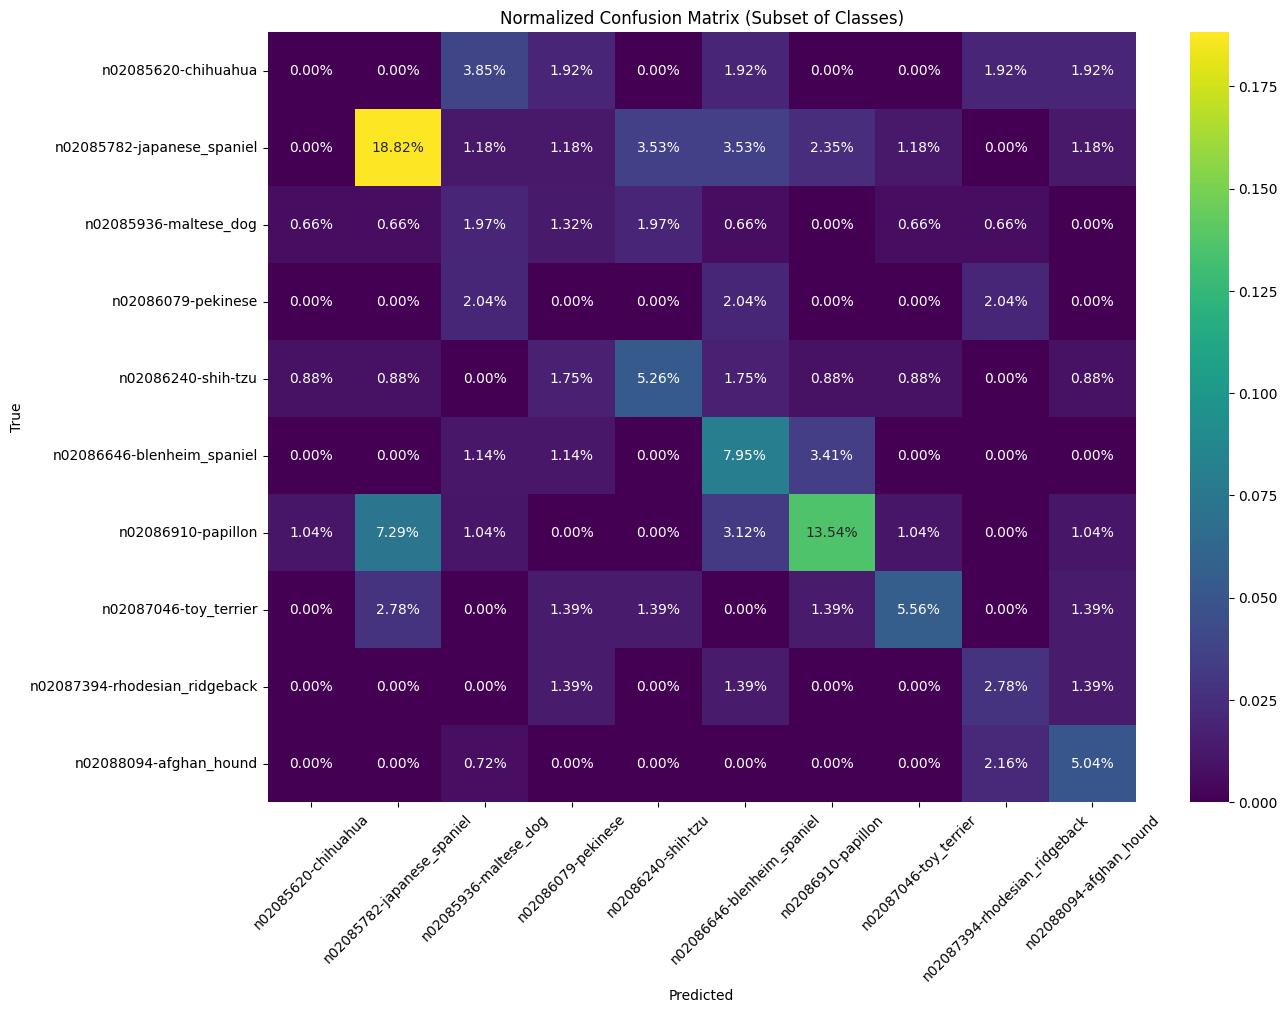

In [76]:
# Normalize the confusion matrix
conf_matrix = confusion_matrix(true_labels.numpy(), predicted_labels.numpy(), normalize='true')

# Select a subset of classes for visualization
selected_classes = info.features['label'].names[:10]

# Find the indices corresponding to the selected classes
selected_indices = [info.features['label'].names.index(cls) for cls in selected_classes]

# Create a subset of the confusion matrix
conf_matrix_subset = conf_matrix[selected_indices][:, selected_indices]

# Increase figure size
plt.figure(figsize=(14, 10))

# Create heatmap with subset of classes
sns.heatmap(conf_matrix_subset, annot=True, fmt='.2%', cmap='viridis', xticklabels=selected_classes, yticklabels=selected_classes)

# Rotate axis labels
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (Subset of Classes)')
plt.show()

# 1. **Data Preparation:**
   - **Dataset:** Used the Stanford Dogs dataset, containing images of 120 dog breeds.
   - **Data Loading:** Loaded the dataset using TensorFlow Datasets (TFDS).
   - **Data Exploration:** Explored class labels, checked for the existence of training and test splits, and visualized sample images.

# 2. **Data Preprocessing:**
   - **Image Resizing:** Resized images to a square shape of dimensions 128x128 pixels.
   - **Normalization:** Scaled pixel values to the range [0, 1].
   - **One-Hot Encoding:** Converted class labels to one-hot encoded vectors.

# 3. **Model Architecture:**
   - **Convolutional Neural Network (CNN):**
      - **Layers:** Utilized convolutional layers, batch normalization, max-pooling, flattening, dense layers, and dropout for regularization.
      - **Activation Functions:** Used ReLU activation in convolutional layers and softmax activation in the output layer.
      - **Optimizer:** Employed Adagrad as the optimizer with a learning rate of 0.04.
      - **Loss Function:** Applied categorical crossentropy as the loss function.

# 4. **Training Strategy:**
   - **Batching and Shuffling:** Batching and shuffling were applied to both training and test datasets.
   - **Callbacks:** Incorporated callbacks such as EarlyStopping, ModelCheckpoint, and a LearningRateScheduler during training.

# 5. **Training Process:**
   - **Learning Rate Schedule:** Implemented a learning rate scheduler that reduces the learning rate by 10% every 5 epochs.
   - **Epochs:** Trained the model for 20 epochs.

# 6. **Evaluation:**
   - **Test Set Evaluation:** Loaded the best model based on the ModelCheckpoint callback.
   - **Metrics:** Evaluated the model on the test set, computing test loss, test accuracy, and generating predictions.
   - **Confusion Matrix:** Calculated a confusion matrix to analyze the model's performance across different classes.

# 7. **Results and Analysis:**
   - **Test Accuracy:** Achieved an overall test accuracy of 7.77%.
   - **Confusion Matrix Visualization:** Visualized a subset of classes in the normalized confusion matrix, highlighting potential misclassifications.

# 8. **Challenges and Solutions:**
   - **Overfitting:** Noticed signs of overfitting as the validation accuracy decreased while training accuracy increased.

   - **Model Generalization:** Model struggled to generalize to the test set.

# 9. **Insights:**
   - **Model Strengths:** The model showed improvement in training accuracy over epochs, indicating some capacity to learn from the data.
   - **Areas for Improvement:** The model's poor generalization to the test set suggests a need for further experimentation, possibly with more complex architectures or additional data preprocessing.

# 10. **Conclusion:**
   - **Recommendations:** Consider experimenting with different model architectures, hyperparameters, and data augmentation techniques to improve generalization.
   - **Iterative Approach:** Fine-tune the model based on insights gained from the confusion matrix and test set evaluation.

# 11. **Final Thoughts:**
   - **Next Steps:** Propose potential avenues for improvement, including adjusting model complexity, trying different optimization algorithms, or exploring transfer learning.